# Mathew Ehab Shokralla Malaga - 1805787

# CSE477s: Project 2 - Fashion MNIST

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Dense, Flatten
from keras.callbacks import LearningRateScheduler, EarlyStopping

BATCH_SIZE = 4096

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)                    
random.seed(seed)

## Reading Data and pre-processing

In [3]:
train = pd.read_csv("fashion-mnist/fashion-mnist_train.csv")
test = pd.read_csv("fashion-mnist/fashion-mnist_test.csv")

In [4]:
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [5]:
train['label'].describe()

count    60000.000000
mean         4.500000
std          2.872305
min          0.000000
25%          2.000000
50%          4.500000
75%          7.000000
max          9.000000
Name: label, dtype: float64

## Labels Frequency Analysis

In [6]:
def num_to_cloth(argument):
    switcher = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }
    return switcher.get(argument, "nothing")

In [7]:
elements_count = {}
for element in train["label"]:
   if element in elements_count:
      elements_count[element] += 1
   else:
      elements_count[element] = 1
print(type(elements_count))
for key, value in sorted(elements_count.items()):
   print(f"{key}: {value} => {num_to_cloth(key)}")

<class 'dict'>
0: 6000 => T-shirt/top
1: 6000 => Trouser
2: 6000 => Pullover
3: 6000 => Dress
4: 6000 => Coat
5: 6000 => Sandal
6: 6000 => Shirt
7: 6000 => Sneaker
8: 6000 => Bag
9: 6000 => Ankle boot


In [8]:
train.label.value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [9]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(train.shape)
print(test.shape)

(60000, 785)
(10000, 785)


In [12]:
print(f"Training samples {train.shape[0]}\nTesting samples {test.shape[0]} \n")

Training samples 60000
Testing samples 10000 



## Cleaning the data from NULL or Duplicates

In [13]:
train.isnull().sum().sum()

0

In [14]:
count = 0
for element in train.duplicated():
    count = count + 1 if (element == True) else count
print("Duplicated samples:", count)

Duplicated samples: 43


In [15]:
pixels = list(train.columns)[1:]
print(train.shape)
train.drop_duplicates(subset=pixels, inplace=True)
print(train.shape)

(60000, 785)
(59957, 785)


## Visualizing some of the images

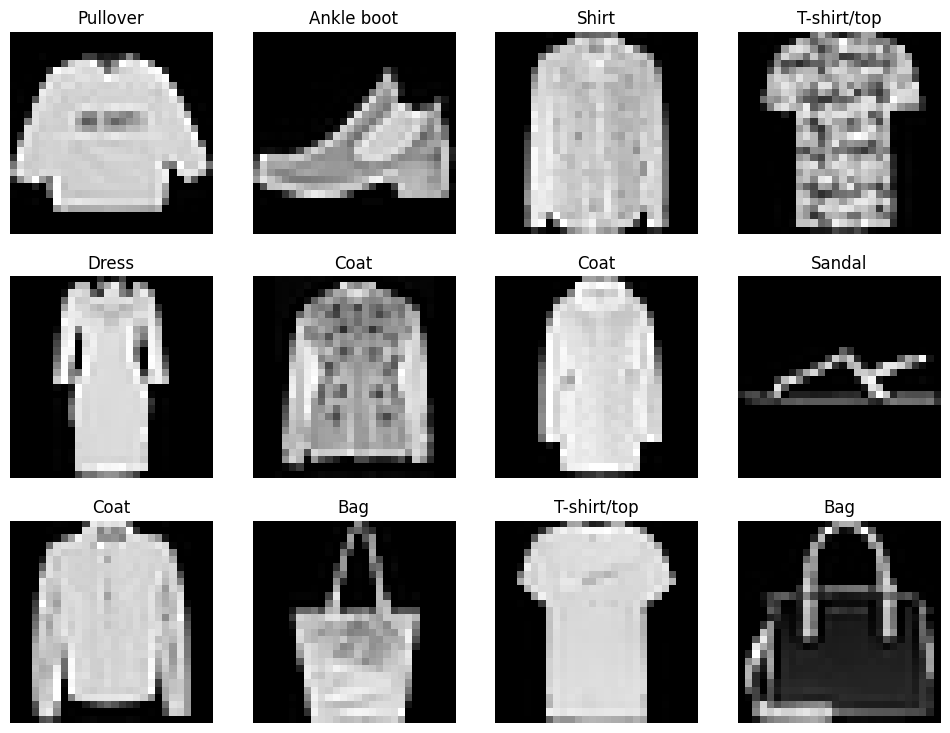

In [21]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(12,9))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    image_resized = np.resize(train.iloc[i,1:].values,(28,28))
    plt.title(class_names[train.iloc[i,0]])
    plt.imshow(image_resized, cmap='gray', interpolation='none')
    plt.axis('off')

## Extracting Features and Labels from the data

In [22]:
X_train = np.array(train.iloc[:, 1:])
y_train = to_categorical(np.array(train.iloc[:, 0]))

In [23]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [24]:
X_test = np.array(test.iloc[:, 1:])
y_test = to_categorical(np.array(test.iloc[:, 0]))

In [25]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Correlation Analysis

In [27]:
corr_matrix = train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
upper_tri.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
label,NaN,0.000676,0.002942,0.010453,0.007119,0.004629,0.011058,0.036828,0.085385,0.161761,...,0.362817,0.258533,0.183235,0.090386,0.077161,0.066846,0.018054,0.045588,0.059963,0.021773
pixel1,NaN,NaN,0.297899,0.067551,0.046607,0.026630,0.026172,0.012096,0.012225,0.009644,...,0.000641,0.004628,0.004609,0.000975,0.002305,0.002442,0.000109,0.008764,0.026388,0.041581
pixel2,NaN,NaN,NaN,0.575033,0.138709,0.054353,0.033184,0.022766,0.017138,0.016821,...,0.000494,0.004861,0.006817,0.002097,0.004427,0.002341,0.004271,0.014215,0.021296,0.022161
pixel3,NaN,NaN,NaN,NaN,0.387468,0.118136,0.087300,0.060937,0.035942,0.029674,...,0.010095,0.016706,0.018323,0.006163,0.003821,0.001494,0.006861,0.013151,0.009946,0.015657
pixel4,NaN,NaN,NaN,NaN,NaN,0.573172,0.325683,0.242987,0.141033,0.085302,...,0.009690,0.018710,0.023391,0.016759,0.009700,0.010101,0.023940,0.012388,0.003072,0.008422


In [28]:
im_rows, im_cols = 28, 28
input_shape = (im_rows, im_cols, 1)

# train and validate sets
X_train = X_train.reshape(X_train.shape[0], im_rows, im_cols, 1)
X_test = X_test.reshape(X_test.shape[0], im_rows, im_cols, 1)

# normalisation
X_train = X_train/255
X_test = X_test/255

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (59957, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
y_train shape: (59957, 10)
y_test shape: (10000, 10)


# LeNet-5 Architecture

In [29]:
def lenet5(input_sh, opt=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    model = Sequential(
        [
            Conv2D(filters = 6, kernel_size = (5, 5), strides = (1, 1), activation = "tanh", input_shape = input_sh),
            AveragePooling2D(pool_size = (2, 2)),
            Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), activation = "tanh"),
            AveragePooling2D(pool_size = (2, 2), strides = 2),
            
            Flatten(),
            Dense(units = 120, activation = "tanh"),
            Dense(units = 84, activation = "tanh"),
            Dense(units = 10, activation = "softmax")
        ]
    )
    
    model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    model.summary()
    
    return model

## Adam Optimizer

In [30]:
model_1 = lenet5(input_shape, tf.keras.optimizers.Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
k = 5
cross_val = KFold(k, shuffle=True, random_state=1)
fold_count = 1

# For training epochs
epochs = 32

# For loss & acc plotting
histories = []

# For testing/evaluation acc scores
eval_scores = []

# For callbacks
es_callbacks = EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)

In [32]:
for train, validation in cross_val.split(X_train):
    print("="*80)
    print("Fold-{}".format(fold_count))
    print("-"*80)
    print("Training & Validation")
    fold_count = fold_count + 1
    
    
    X_train_, y_train_ = X_train[train], y_train[train]
    X_val, y_val = X_train[validation], y_train[validation]
    
    history = model_1.fit(X_train_, y_train_,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[es_callbacks])
    
    print("-"*80)
    print("Testing/evaluation")
    eval_loss, eval_accuracy = model_1.evaluate(X_test, y_test)
    
    histories.append(history)
    eval_scores.append(eval_accuracy)
    print("_"*80)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/32
1499/1499 [==============================] - 19s 12ms/step - loss: 0.5955 - accuracy: 0.7785 - val_loss: 0.4877 - val_accuracy: 0.8194
Epoch 2/32
1499/1499 [==============================] - 18s 12ms/step - loss: 0.4225 - accuracy: 0.8462 - val_loss: 0.4218 - val_accuracy: 0.8502
Epoch 3/32
1499/1499 [==============================] - 8s 5ms/step - loss: 0.3734 - accuracy: 0.8635 - val_loss: 0.3800 - val_accuracy: 0.8622
Epoch 4/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3414 - accuracy: 0.8754 - val_loss: 0.3669 - val_accuracy: 0.8677
Epoch 5/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3212 - accuracy: 0.8819 - val_loss: 0.3449 - val_accuracy: 0.8777
Epoch 6/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3012 - accuracy: 0.8877 - val_loss: 0.3476 - val_accuracy: 0.8727
Epoch 7/32
1499/1499 [

In [33]:
def display_kfold_result(history, k=1):
    # Train & Val Loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Train & Val Accuracy
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(accuracy, label="Training")
    plt.plot(val_accuracy, label="Validation")
    plt.legend(loc="lower right")
    
    plt.suptitle("Fold-{}".format(k))
    plt.show()

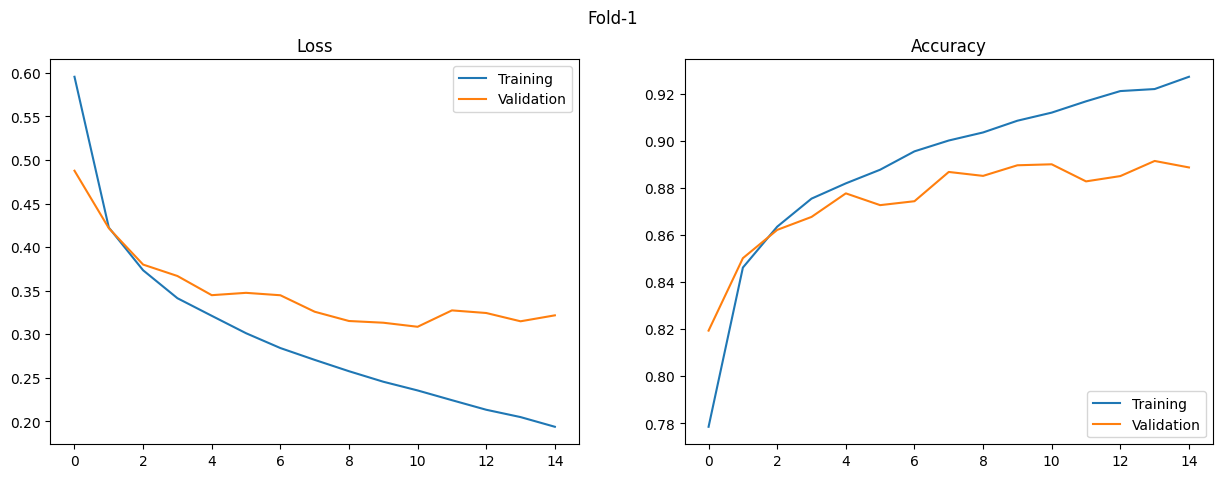

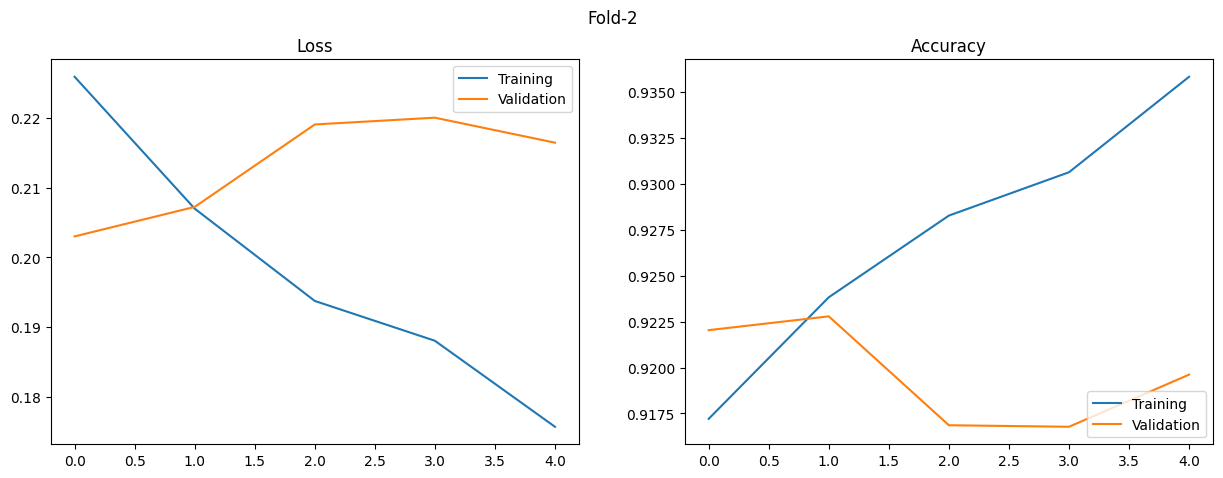

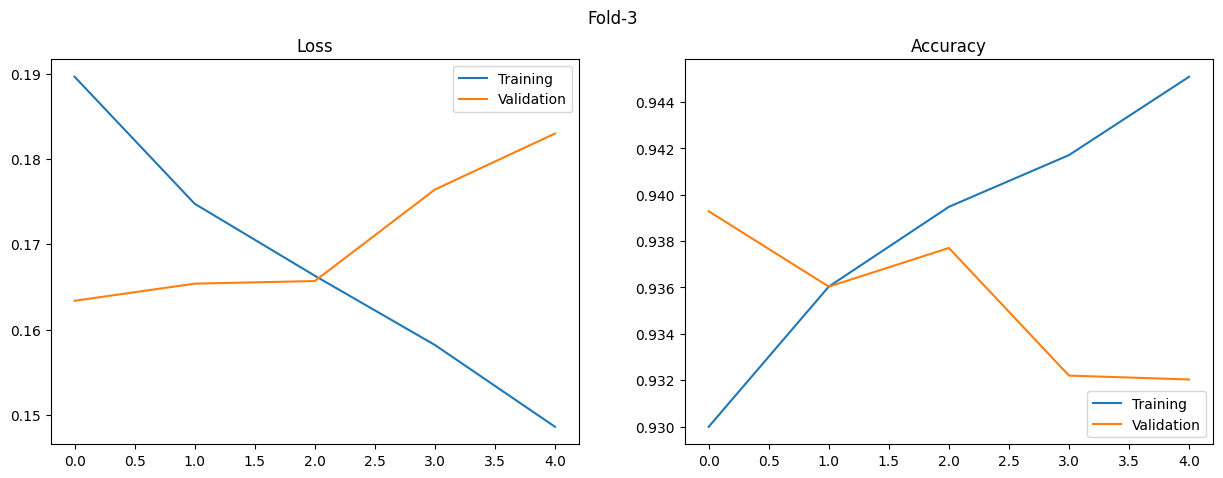

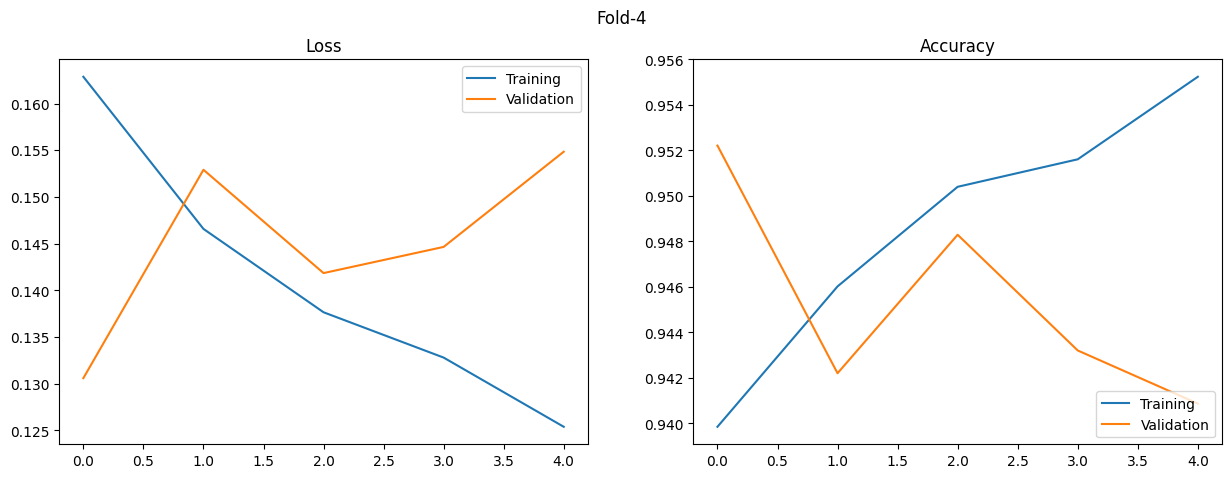

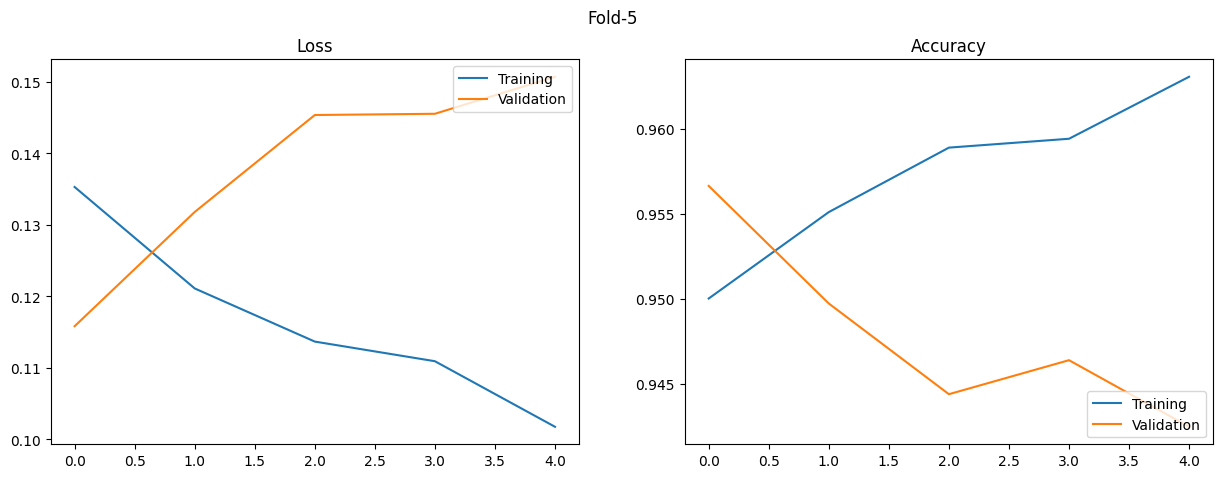

In [34]:
for history in histories:
    display_kfold_result(history, (histories.index(history)+1))

In [35]:
i = 0
float2 = "{0:.2f}"
for score in eval_scores:
    percent = score * 100
    print("Fold-{}: {}%".format(i+1, float2.format(percent)))
    i = i + 1

Fold-1: 88.83%
Fold-2: 89.40%
Fold-3: 89.25%
Fold-4: 89.15%
Fold-5: 89.04%


## RMSProp Optimizer

In [36]:
model_2 = lenet5(input_shape, tf.keras.optimizers.RMSprop(learning_rate=0.001))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 12, 12, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
k = 5
cross_val = KFold(k, shuffle=True, random_state=1)
fold_count = 1

# For training epochs
epochs = 32

# For loss & acc plotting
histories = []

# For testing/evaluation acc scores
eval_scores = []

# For callbacks
es_callbacks = EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)

In [38]:
for train, validation in cross_val.split(X_train):
    print("="*80)
    print("Fold-{}".format(fold_count))
    print("-"*80)
    print("Training & Validation")
    fold_count = fold_count + 1
    
    
    X_train_, y_train_ = X_train[train], y_train[train]
    X_val, y_val = X_train[validation], y_train[validation]
    
    history = model_2.fit(X_train_, y_train_,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[es_callbacks])
    
    print("-"*80)
    print("Testing/evaluation")
    eval_loss, eval_accuracy = model_2.evaluate(X_test, y_test)
    
    histories.append(history)
    eval_scores.append(eval_accuracy)
    print("_"*80)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.5865 - accuracy: 0.7811 - val_loss: 0.4952 - val_accuracy: 0.8139
Epoch 2/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.4238 - accuracy: 0.8452 - val_loss: 0.4154 - val_accuracy: 0.8479
Epoch 3/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3751 - accuracy: 0.8629 - val_loss: 0.3835 - val_accuracy: 0.8620
Epoch 4/32
1499/1499 [==============================] - 6s 4ms/step - loss: 0.3435 - accuracy: 0.8750 - val_loss: 0.3650 - val_accuracy: 0.8690
Epoch 5/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3217 - accuracy: 0.8818 - val_loss: 0.3455 - val_accuracy: 0.8781
Epoch 6/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3012 - accuracy: 0.8888 - val_loss: 0.3417 - val_accuracy: 0.8773
Epoch 7/32
1499/1499 [====

In [39]:
def display_kfold_result(history, k=1):
    # Train & Val Loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Train & Val Accuracy
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(accuracy, label="Training")
    plt.plot(val_accuracy, label="Validation")
    plt.legend(loc="lower right")
    
    plt.suptitle("Fold-{}".format(k))
    plt.show()

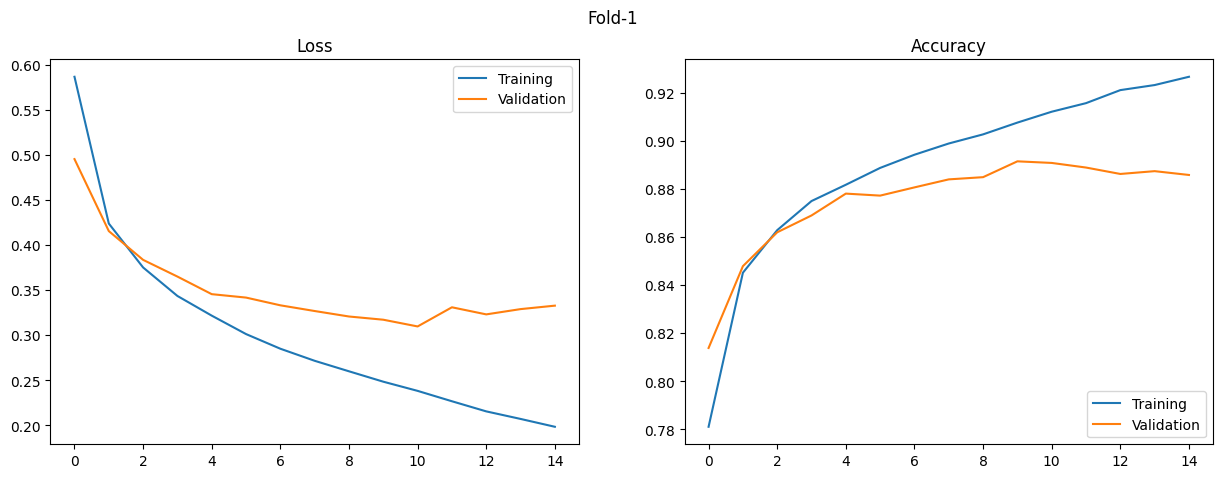

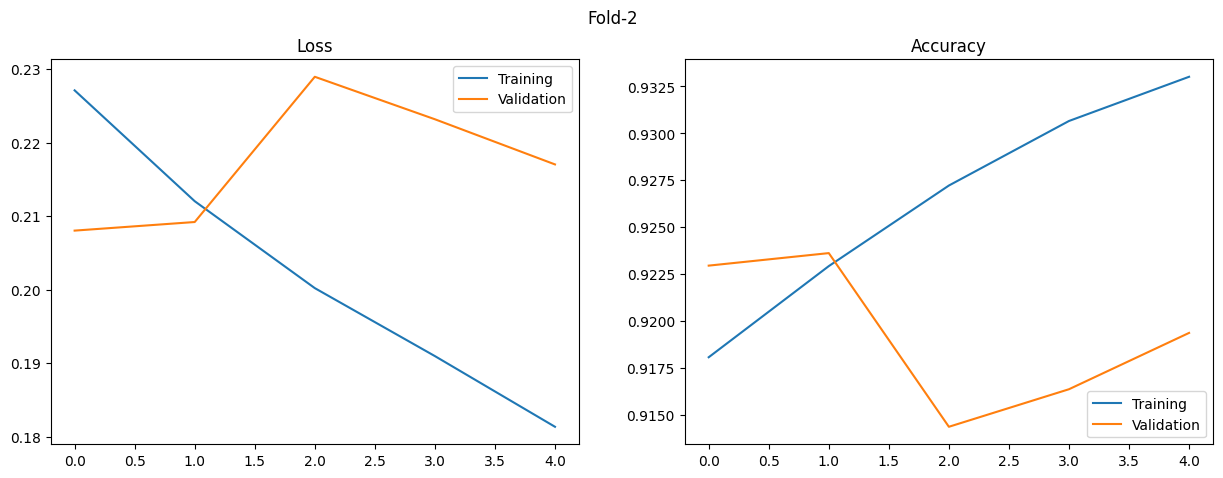

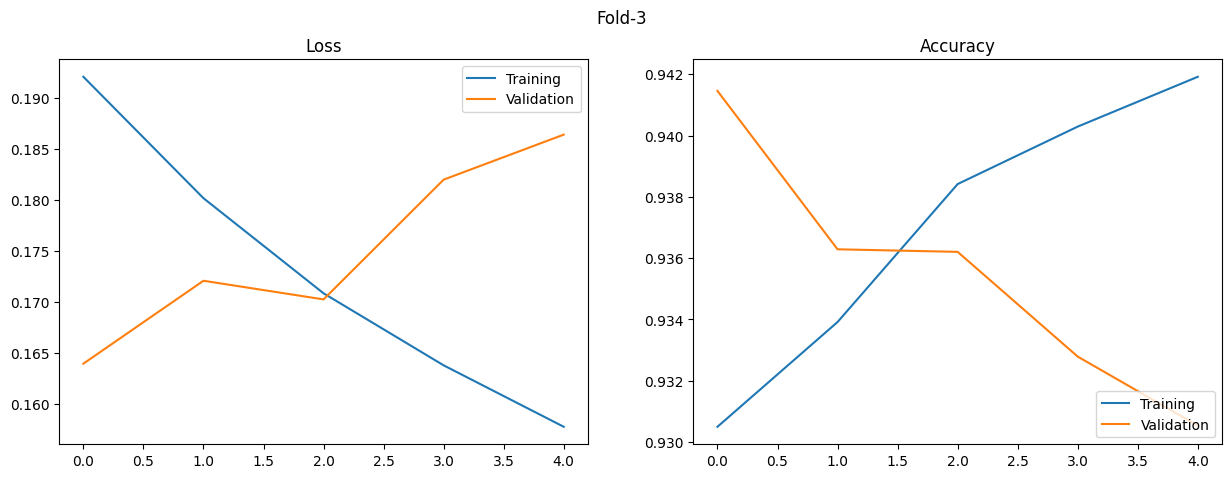

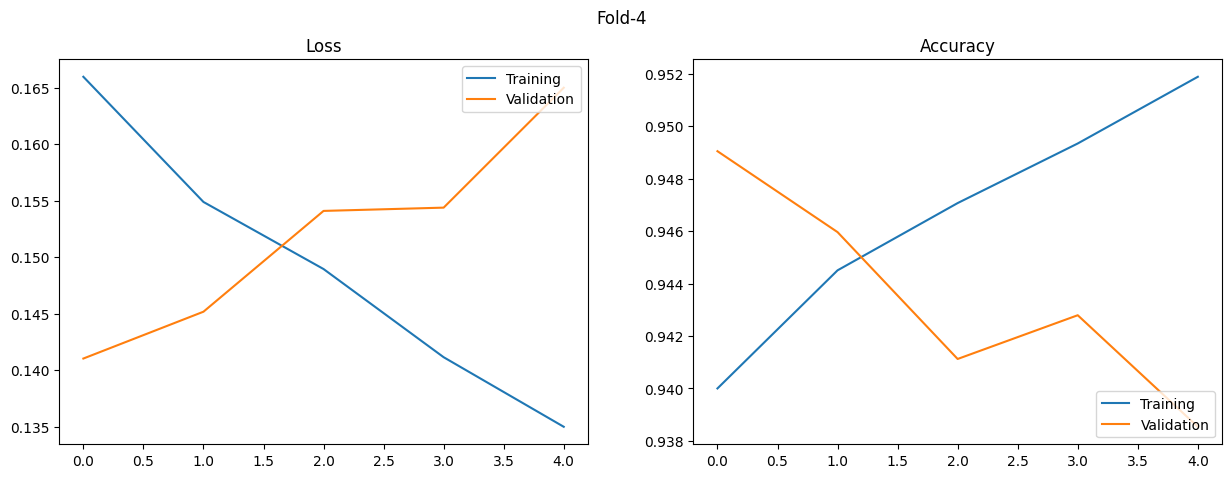

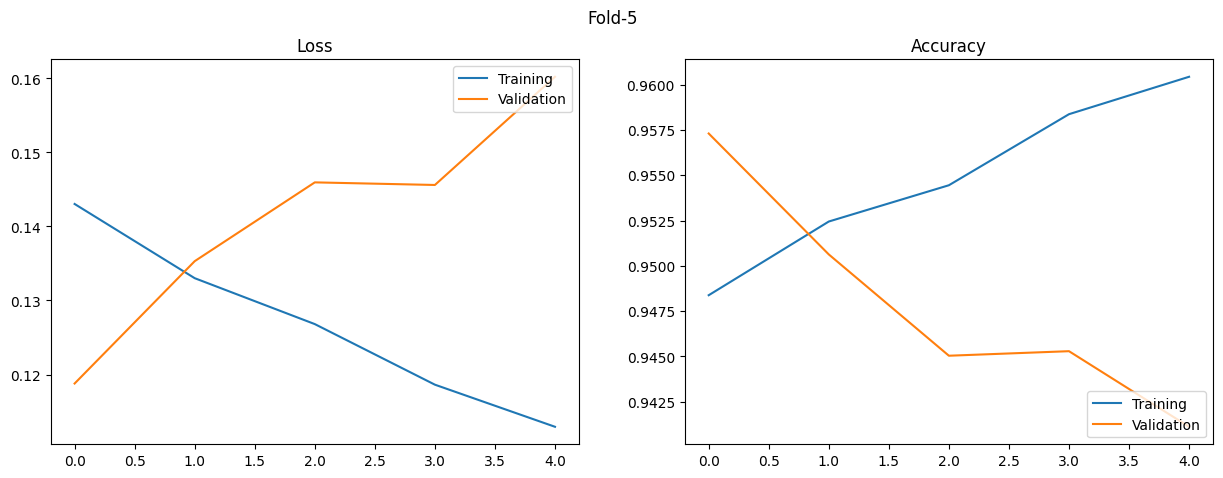

In [40]:
for history in histories:
    display_kfold_result(history, (histories.index(history)+1))

In [41]:
i = 0
float2 = "{0:.2f}"
for score in eval_scores:
    percent = score * 100
    print("Fold-{}: {}%".format(i+1, float2.format(percent)))

Fold-1: 88.53%
Fold-1: 89.29%
Fold-1: 89.00%
Fold-1: 89.19%
Fold-1: 88.63%


## SGD Optimizer

In [42]:
model_3 = lenet5(input_shape, tf.keras.optimizers.SGD(learning_rate=0.001))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d_4 (Averag  (None, 12, 12, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
k = 5
cross_val = KFold(k, shuffle=True, random_state=1)
fold_count = 1

# For training epochs
epochs = 32

# For loss & acc plotting
histories = []

# For testing/evaluation acc scores
eval_scores = []

# For callbacks
es_callbacks = EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)

In [44]:
for train, validation in cross_val.split(X_train):
    print("="*80)
    print("Fold-{}".format(fold_count))
    print("-"*80)
    print("Training & Validation")
    fold_count = fold_count + 1
    
    
    X_train_, y_train_ = X_train[train], y_train[train]
    X_val, y_val = X_train[validation], y_train[validation]
    
    history = model_3.fit(X_train_, y_train_,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[es_callbacks])
    
    print("-"*80)
    print("Testing/evaluation")
    eval_loss, eval_accuracy = model_3.evaluate(X_test, y_test)
    
    histories.append(history)
    eval_scores.append(eval_accuracy)
    print("_"*80)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/32
1499/1499 [==============================] - 8s 5ms/step - loss: 1.8717 - accuracy: 0.3661 - val_loss: 1.3729 - val_accuracy: 0.5724
Epoch 2/32
1499/1499 [==============================] - 7s 5ms/step - loss: 1.1511 - accuracy: 0.6330 - val_loss: 1.0337 - val_accuracy: 0.6478
Epoch 3/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.9493 - accuracy: 0.6829 - val_loss: 0.9058 - val_accuracy: 0.6831
Epoch 4/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.8482 - accuracy: 0.7071 - val_loss: 0.8288 - val_accuracy: 0.7031
Epoch 5/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.7854 - accuracy: 0.7211 - val_loss: 0.7799 - val_accuracy: 0.7142
Epoch 6/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.7428 - accuracy: 0.7311 - val_loss: 0.7445 - val_accuracy: 0.7236
Epoch 7/32
1499/1499 [====

1499/1499 [==============================] - 7s 5ms/step - loss: 0.4303 - accuracy: 0.8456 - val_loss: 0.4415 - val_accuracy: 0.8441
Epoch 22/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.4283 - accuracy: 0.8464 - val_loss: 0.4404 - val_accuracy: 0.8431
Epoch 23/32
1499/1499 [==============================] - 8s 5ms/step - loss: 0.4263 - accuracy: 0.8466 - val_loss: 0.4378 - val_accuracy: 0.8467
Epoch 24/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.4243 - accuracy: 0.8478 - val_loss: 0.4369 - val_accuracy: 0.8433
Epoch 25/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.4222 - accuracy: 0.8483 - val_loss: 0.4349 - val_accuracy: 0.8471
Epoch 26/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.4204 - accuracy: 0.8491 - val_loss: 0.4331 - val_accuracy: 0.8463
Epoch 27/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.4185 - accuracy: 0.8494 - val_loss: 0.4317 - val_accuracy: 0.84

1499/1499 [==============================] - 7s 4ms/step - loss: 0.3644 - accuracy: 0.8711 - val_loss: 0.3529 - val_accuracy: 0.8704
Epoch 8/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3631 - accuracy: 0.8723 - val_loss: 0.3545 - val_accuracy: 0.8712
Epoch 9/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3624 - accuracy: 0.8718 - val_loss: 0.3505 - val_accuracy: 0.8702
Epoch 10/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3613 - accuracy: 0.8720 - val_loss: 0.3521 - val_accuracy: 0.8716
Epoch 11/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3600 - accuracy: 0.8726 - val_loss: 0.3490 - val_accuracy: 0.8709
Epoch 12/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3593 - accuracy: 0.8729 - val_loss: 0.3496 - val_accuracy: 0.8716
Epoch 13/32
1499/1499 [==============================] - 7s 4ms/step - loss: 0.3582 - accuracy: 0.8731 - val_loss: 0.3483 - val_accuracy: 0.8724

1499/1499 [==============================] - 7s 5ms/step - loss: 0.3194 - accuracy: 0.8861 - val_loss: 0.3324 - val_accuracy: 0.8814
Epoch 29/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3187 - accuracy: 0.8863 - val_loss: 0.3351 - val_accuracy: 0.8801
Epoch 30/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3182 - accuracy: 0.8871 - val_loss: 0.3327 - val_accuracy: 0.8807
Epoch 31/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3174 - accuracy: 0.8870 - val_loss: 0.3315 - val_accuracy: 0.8819
Epoch 32/32
1499/1499 [==============================] - 7s 5ms/step - loss: 0.3168 - accuracy: 0.8871 - val_loss: 0.3355 - val_accuracy: 0.8800
--------------------------------------------------------------------------------
Testing/evaluation
313/313 [==============================] - 1s 2ms/step - loss: 0.3373 - accuracy: 0.8764
________________________________________________________________________________


In [45]:
def display_kfold_result(history, k=1):
    # Train & Val Loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Train & Val Accuracy
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(accuracy, label="Training")
    plt.plot(val_accuracy, label="Validation")
    plt.legend(loc="lower right")
    
    plt.suptitle("Fold-{}".format(k))
    plt.show()

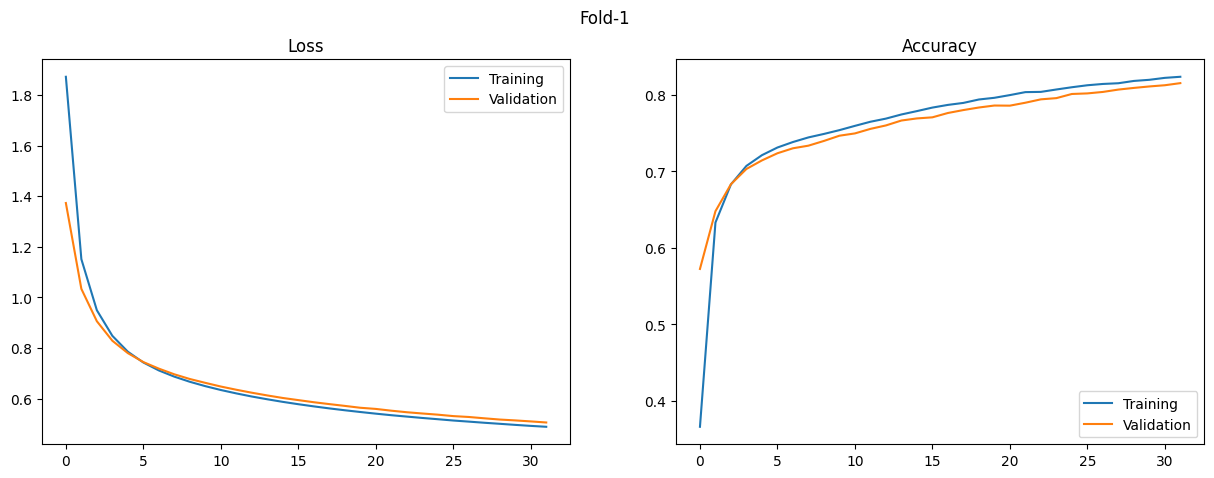

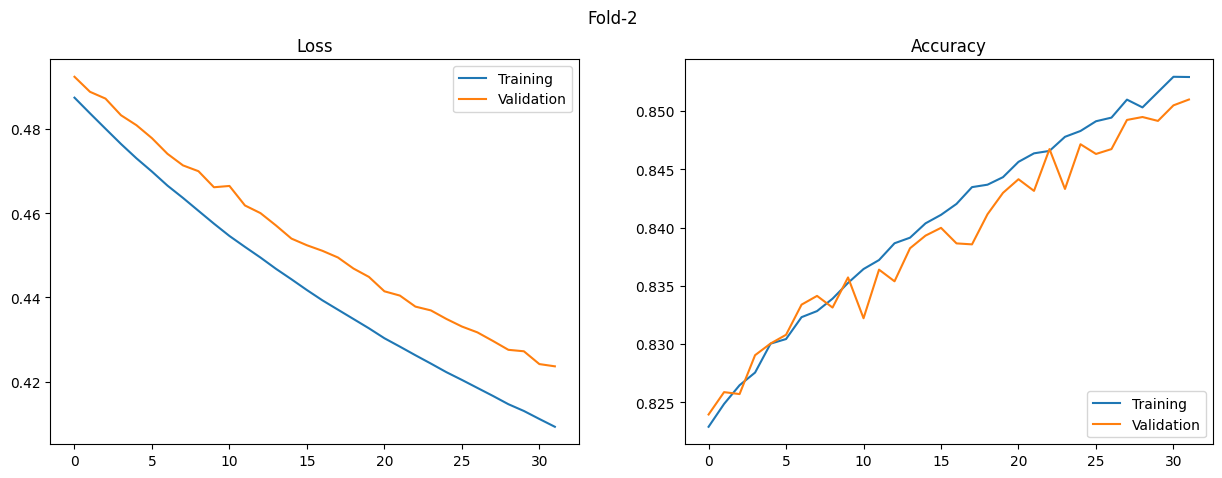

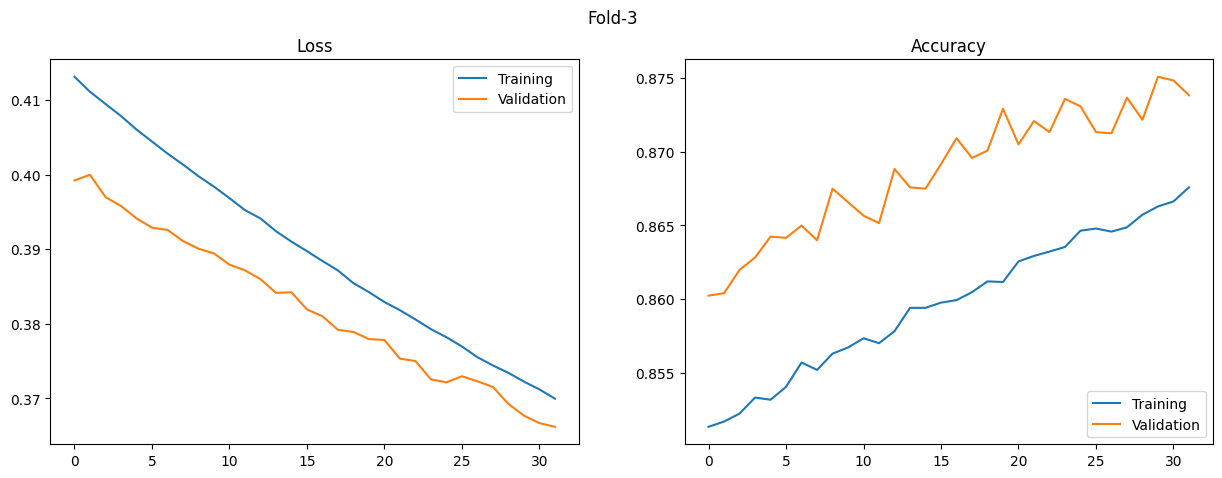

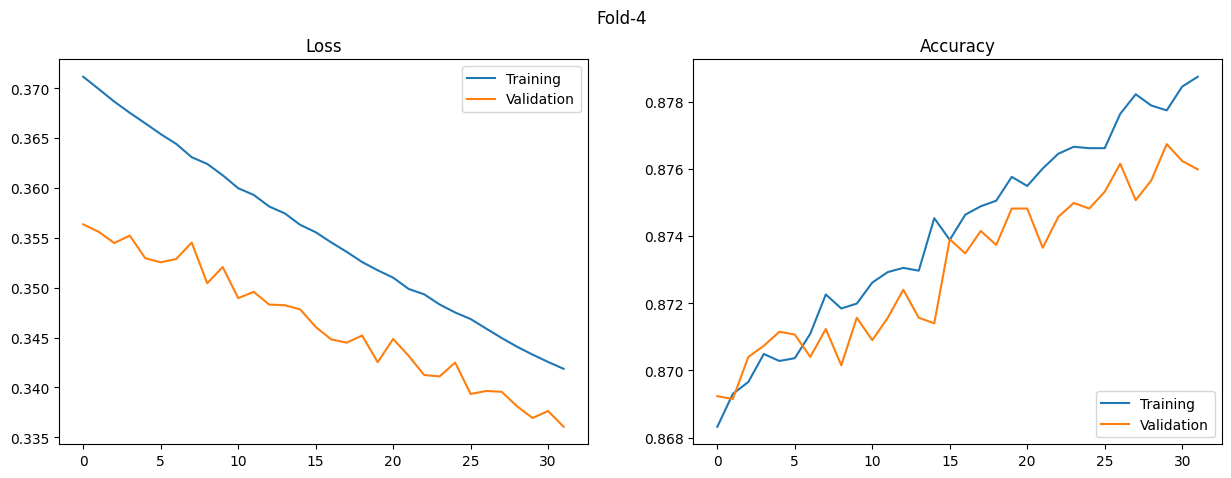

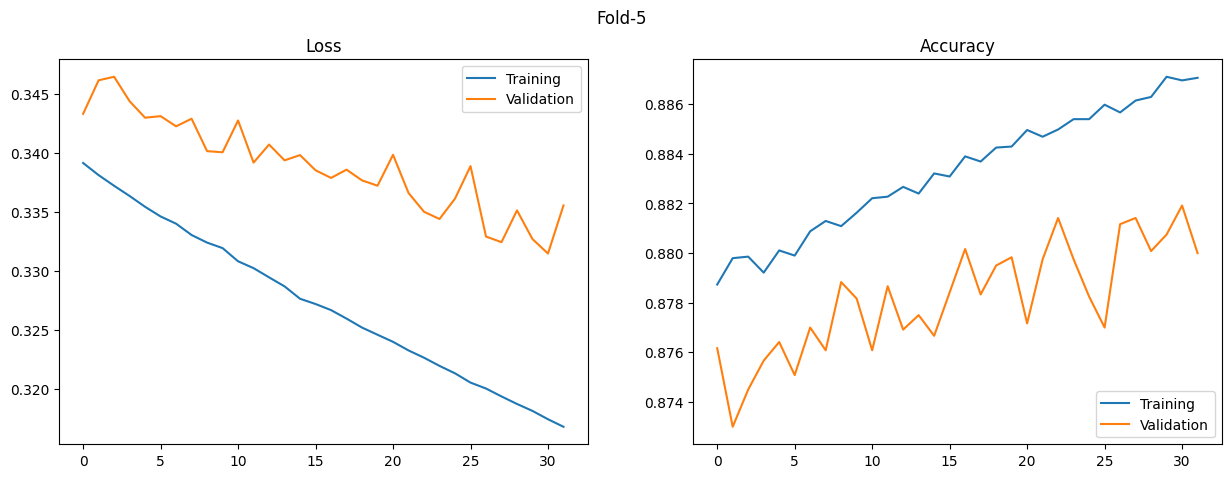

In [46]:
for history in histories:
    display_kfold_result(history, (histories.index(history)+1))

In [47]:
i = 0
float2 = "{0:.2f}"
for score in eval_scores:
    percent = score * 100
    print("Fold-{}: {}%".format(i+1, float2.format(percent)))
    i = i + 1

Fold-1: 82.66%
Fold-2: 85.26%
Fold-3: 86.39%
Fold-4: 87.11%
Fold-5: 87.64%


# Transfer Learning

In [48]:
import cv2
def to_3_channels(X_1):
    X_3 = np.empty([X_1.shape[0], X_1.shape[1], X_1.shape[2], 3], dtype=float)

    for i in range(X_1.shape[0]):
        X_3[i] = cv2.merge([X_1[i],X_1[i],X_1[i]])
        
    return X_3

In [49]:
def resize_image(X_3, x_size, y_size):
    X_3_resized = np.empty([X_3.shape[0], x_size, y_size, 3], dtype=float)

    for i in range(X_3.shape[0]):
        X_3_resized[i] = tf.image.resize(X_3[i], (x_size, y_size))
        
    return X_3_resized

### Transforming Images

In [50]:
X_train_3_32 = resize_image(to_3_channels(X_train), 32, 32)
X_test_3_32 = resize_image(to_3_channels(X_test), 32, 32)

In [51]:
print(X_train_3_32.shape, X_train.shape)
print(X_test_3_32.shape, X_test.shape)

(59957, 32, 32, 3) (59957, 28, 28, 1)
(10000, 32, 32, 3) (10000, 28, 28, 1)


(59957, 28, 28, 1) (59957, 28, 28, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0.] [0. 0. 0.] 0.0


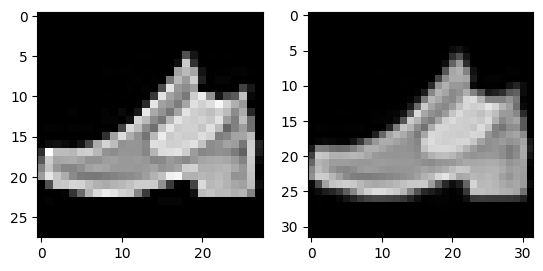

In [52]:
print(X_train.shape, to_3_channels(X_train).shape)
print(type(X_train), type(to_3_channels(X_train)))
print(X_train[0][0][0], to_3_channels(X_train)[0][0][0], to_3_channels(X_train)[0][0][0][0])

plt.subplot(1, 2, 1)
plt.imshow(256*X_train[1], cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 2, 2)
plt.imshow(X_train_3_32[1], cmap='brg', vmin=0, vmax=255)

plt.show()

## VGG16

In [53]:
from keras.models import Model

In [54]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten

model_VGG16 = VGG16(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers
for layer in model_VGG16.layers[:]:
    layer.trainable = False

# Add Dense layer as in VGG16
output = model_VGG16.output
output = Flatten()(output)
output = Dense(units=100, activation='relu')(output)
output = Dense(units=10, activation='softmax')(output)
model_VGG16 = Model(model_VGG16.input, output)
model_VGG16.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [55]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
k = 5
cross_val = KFold(k, shuffle=True, random_state=1)
fold_count = 1

# For training epochs
epochs = 15

# For loss & acc plotting
histories = []

# For testing/evaluation acc scores
eval_scores = []

# For callbacks
es_callbacks = EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)

In [56]:
for train, validation in cross_val.split(X_train):
    print("="*80)
    print("Fold-{}".format(fold_count))
    print("-"*80)
    print("Training & Validation")
    fold_count = fold_count + 1
    
    
    X_train_, y_train_ = X_train_3_32[train], y_train[train]
    X_val, y_val = X_train_3_32[validation], y_train[validation]
    
    history = model_VGG16.fit(X_train_, y_train_,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[es_callbacks])
    
    print("-"*80)
    print("Testing/evaluation")
    eval_loss, eval_accuracy = model_VGG16.evaluate(X_test_3_32, y_test)
    
    histories.append(history)
    eval_scores.append(eval_accuracy)
    print("_"*80)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/15
1499/1499 [==============================] - 117s 77ms/step - loss: 0.5732 - accuracy: 0.7992 - val_loss: 0.4604 - val_accuracy: 0.8278
Epoch 2/15
1499/1499 [==============================] - 119s 79ms/step - loss: 0.4256 - accuracy: 0.8455 - val_loss: 0.4240 - val_accuracy: 0.8452
Epoch 3/15
1499/1499 [==============================] - 123s 82ms/step - loss: 0.3939 - accuracy: 0.8553 - val_loss: 0.4089 - val_accuracy: 0.8512
Epoch 4/15
1499/1499 [==============================] - 122s 81ms/step - loss: 0.3732 - accuracy: 0.8652 - val_loss: 0.4217 - val_accuracy: 0.8436
Epoch 5/15
1499/1499 [==============================] - 119s 79ms/step - loss: 0.3566 - accuracy: 0.8701 - val_loss: 0.3888 - val_accuracy: 0.8594
Epoch 6/15
1499/1499 [==============================] - 119s 79ms/step - loss: 0.3435 - accuracy: 0.8725 - val_loss: 0.3943 - val_accuracy: 0.8558
Epoch 7/

313/313 [==============================] - 20s 64ms/step - loss: 0.3833 - accuracy: 0.8775
________________________________________________________________________________


In [57]:
def display_kfold_result(history, k=1):
    # Train & Val Loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Train & Val Accuracy
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(accuracy, label="Training")
    plt.plot(val_accuracy, label="Validation")
    plt.legend(loc="lower right")
    
    plt.suptitle("Fold-{}".format(k))
    plt.show()

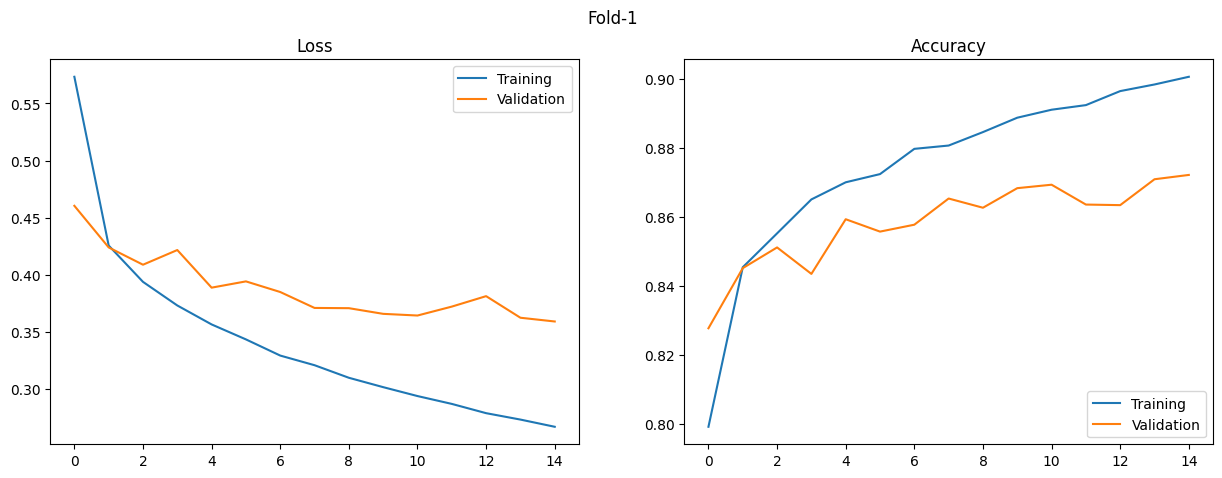

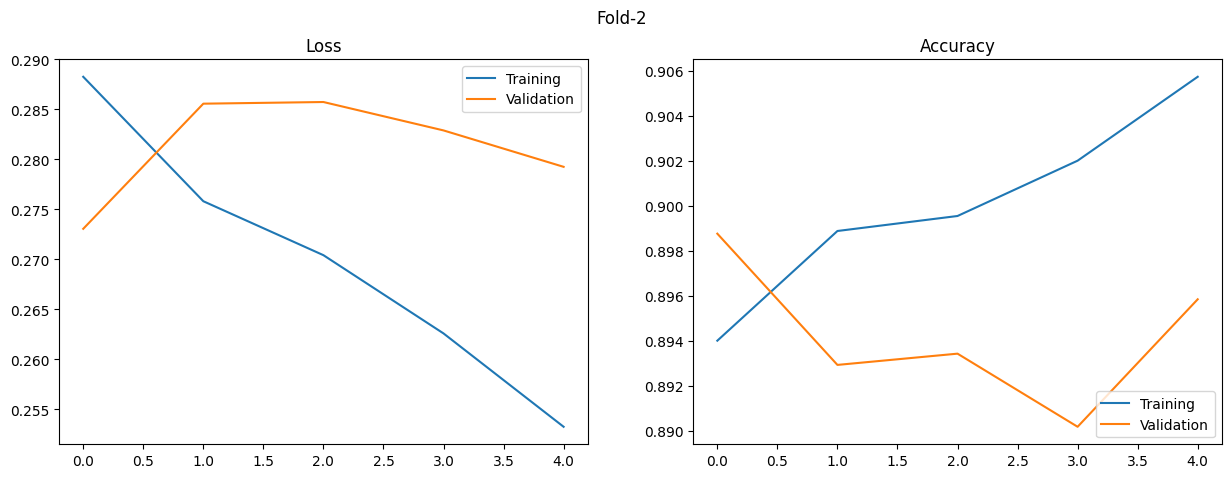

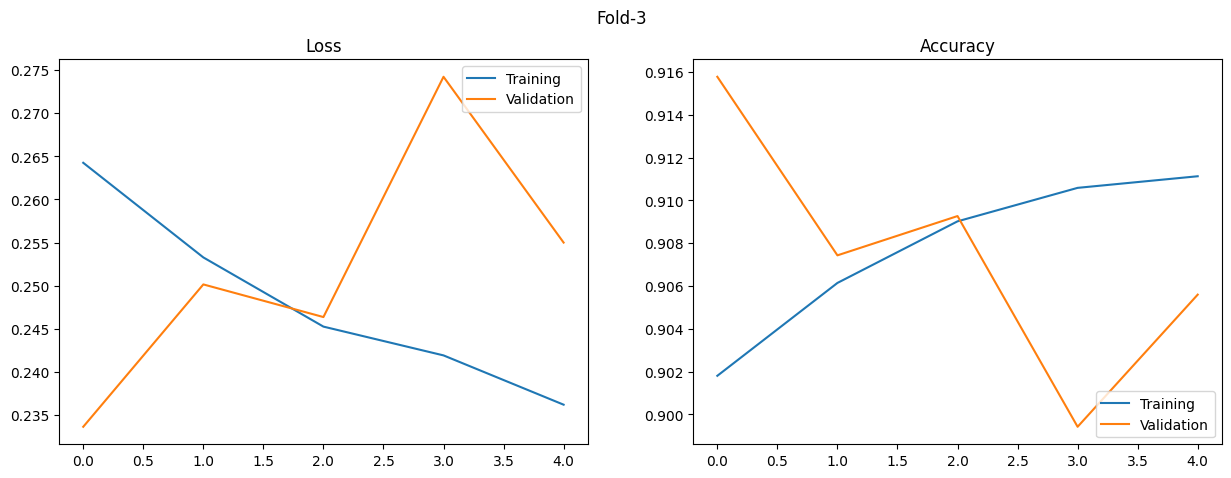

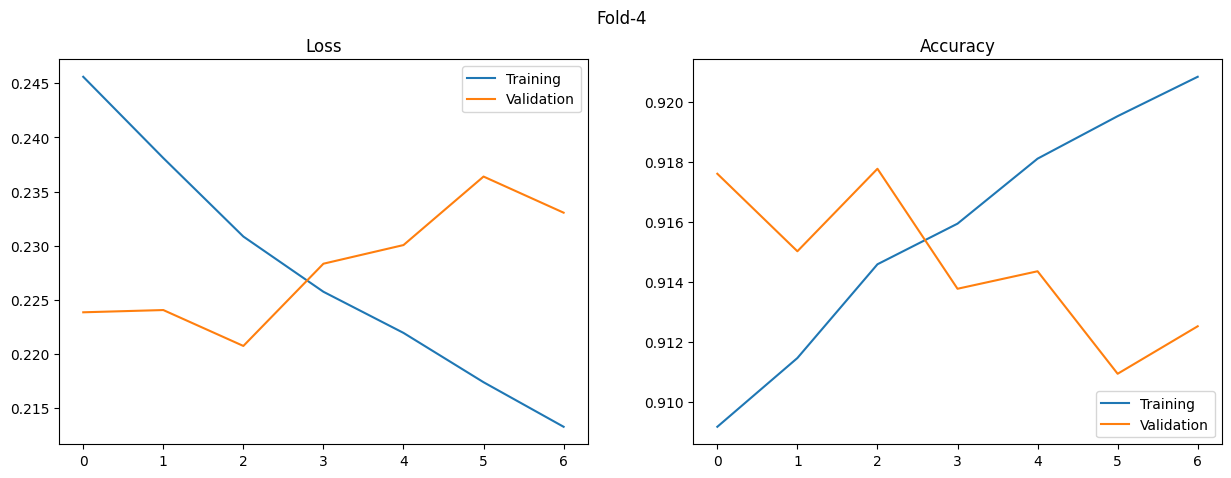

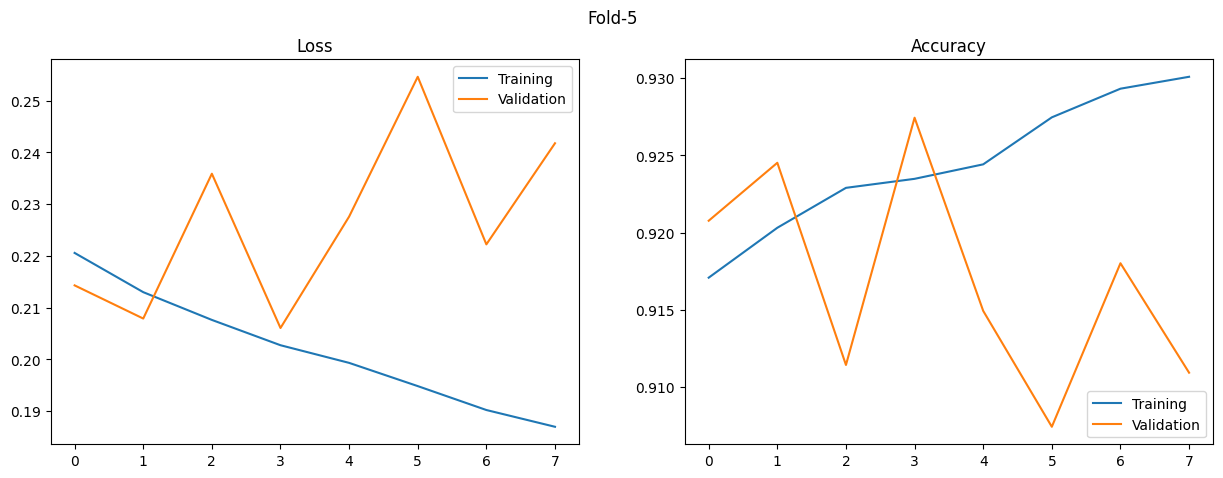

In [58]:
for history in histories:
    display_kfold_result(history, (histories.index(history)+1))

In [59]:
i = 0
float2 = "{0:.2f}"
for score in eval_scores:
    percent = score * 100
    print("Fold-{}: {}%".format(i+1, float2.format(percent)))
    i = i + 1

Fold-1: 87.60%
Fold-2: 88.33%
Fold-3: 88.09%
Fold-4: 88.23%
Fold-5: 87.75%


### ResNet50

In [60]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

model_RESNET = ResNet50(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers
for layer in model_RESNET.layers[:]:
    layer.trainable = False

# Add Dense layer to classify on CIFAR10
output = model_RESNET.output
output = GlobalAveragePooling2D()(output)
output = Dense(units=10, activation='softmax')(output)
model_RESNET = Model(model_RESNET.input, output)
model_RESNET.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_RESNET.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 2, 2, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 1, 1, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 1, 1, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 1, 1, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [67]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
k = 3
cross_val = KFold(k, shuffle=True, random_state=1)
fold_count = 1

# For training epochs
epochs = 5

# For loss & acc plotting
histories = []

# For testing/evaluation acc scores
eval_scores = []

# For callbacks
es_callbacks = EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)

In [68]:
for train, validation in cross_val.split(X_train):
    print("="*80)
    print("Fold-{}".format(fold_count))
    print("-"*80)
    print("Training & Validation")
    fold_count = fold_count + 1
    
    
    X_train_, y_train_ = X_train_3_32[train], y_train[train]
    X_val, y_val = X_train_3_32[validation], y_train[validation]
    
    history = model_RESNET.fit(X_train_, y_train_,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[es_callbacks])
    
    print("-"*80)
    print("Testing/evaluation")
    eval_loss, eval_accuracy = model_RESNET.evaluate(X_test_3_32, y_test)
    
    histories.append(history)
    eval_scores.append(eval_accuracy)
    print("_"*80)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/5
1250/1250 [==============================] - 77s 62ms/step - loss: 0.7473 - accuracy: 0.7308 - val_loss: 0.7475 - val_accuracy: 0.7387
Epoch 2/5
1250/1250 [==============================] - 80s 64ms/step - loss: 0.7043 - accuracy: 0.7444 - val_loss: 0.7492 - val_accuracy: 0.7079
Epoch 3/5
1250/1250 [==============================] - 80s 64ms/step - loss: 0.6823 - accuracy: 0.7500 - val_loss: 0.6704 - val_accuracy: 0.7540
Epoch 4/5
1250/1250 [==============================] - 79s 63ms/step - loss: 0.6645 - accuracy: 0.7576 - val_loss: 0.7236 - val_accuracy: 0.7225
Epoch 5/5
1250/1250 [==============================] - 80s 64ms/step - loss: 0.6533 - accuracy: 0.7608 - val_loss: 0.6515 - val_accuracy: 0.7558
--------------------------------------------------------------------------------
Testing/evaluation
313/313 [==============================] - 15s 49ms/step - loss: 

KeyboardInterrupt: 

In [69]:
def display_kfold_result(history, k=1):
    # Train & Val Loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Train & Val Accuracy
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(accuracy, label="Training")
    plt.plot(val_accuracy, label="Validation")
    plt.legend(loc="lower right")
    
    plt.suptitle("Fold-{}".format(k))
    plt.show()

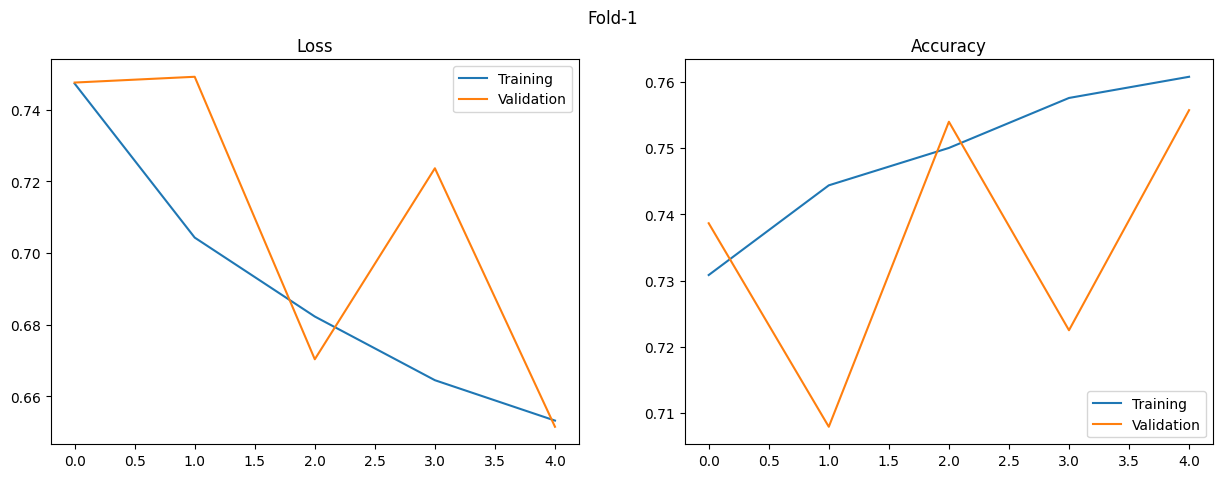

In [70]:
for history in histories:
    display_kfold_result(history, (histories.index(history)+1))

In [71]:
i = 0
float2 = "{0:.2f}"
for score in eval_scores:
    percent = score * 100
    print("Fold-{}: {}%".format(i+1, float2.format(percent)))
    i = i + 1

Fold-1: 76.60%
